In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("final_v3.csv", index_col='일시', parse_dates=True)

FileNotFoundError: [Errno 2] No such file or directory: 'final_v3.csv'

=== Random Forest TimeSeriesSplit 교차검증 시작 ===

Fold 1: Train=1273, Test=1272, RMSE=0.1074, MAPE=170.90%, R²=0.7407, MAE=0.0734, MSE=0.0115
Fold 2: Train=2545, Test=1272, RMSE=0.1170, MAPE=180.91%, R²=0.8080, MAE=0.0782, MSE=0.0137
Fold 3: Train=3817, Test=1272, RMSE=0.1439, MAPE=196.48%, R²=0.7990, MAE=0.0939, MSE=0.0207
Fold 4: Train=5089, Test=1272, RMSE=0.1458, MAPE=313.51%, R²=0.8008, MAE=0.0987, MSE=0.0213
Fold 5: Train=6361, Test=1272, RMSE=0.1483, MAPE=286.06%, R²=0.7881, MAE=0.0947, MSE=0.0220

=== Random Forest 최종 성능 ===
RMSE: 0.1325 ± 0.0169
MAPE: 229.57% ± 58.55%
R²: 0.7873 ± 0.0242
MAE: 0.0878 ± 0.0100

=== Random Forest Feature Importance Top 15 ===
 1. weekday_sin               0.5504 ± 0.0382
 2. is_weekend                0.1964 ± 0.0294
 3. year                      0.0489 ± 0.0221
 4. vapor_pressure            0.0461 ± 0.0142
 5. hr_diff                   0.0301 ± 0.0039
 6. coolingHeating            0.0288 ± 0.0027
 7. ms_diff                   0.0268 ± 0.0027
 8. rel

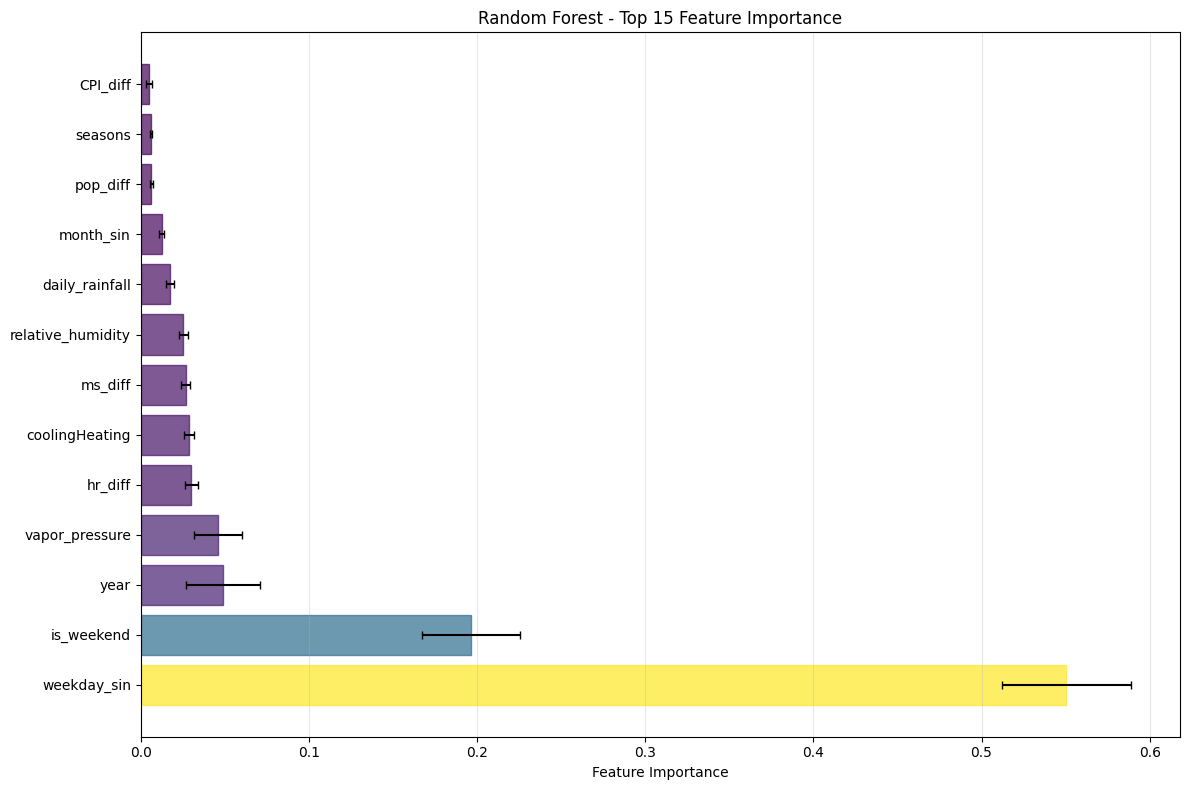


Random Forest 분석이 완료되었습니다!


In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import clone
import seaborn as sns

# 데이터 준비
X = df.loc[:, df.columns != 'maxElec_diff_scaled']
y = df['maxElec_diff_scaled']

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=5)

# Random Forest 모델 정의
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 결과 저장
rf_results = {}
rf_predictions = []
rf_importances = []

print("=== Random Forest TimeSeriesSplit 교차검증 시작 ===\n")

fold_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # 각 fold마다 새로운 모델 인스턴스 사용
    model_copy = clone(rf_model)
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # 모델 학습
    model_copy.fit(X_train, y_train)
    y_pred = model_copy.predict(X_test)
    
    # Feature Importance 저장
    rf_importances.append(model_copy.feature_importances_)
    
    # 모든 평가 지표 계산
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    fold_scores.append({
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'MAE': mae,
        'MSE': mse
    })
    
    rf_predictions.append((y_test, y_pred, test_idx))
    
    print(f"Fold {fold+1}: Train={len(train_idx)}, Test={len(test_idx)}, "
          f"RMSE={rmse:.4f}, MAPE={mape:.2f}%, R²={r2:.4f}, "
          f"MAE={mae:.4f}, MSE={mse:.4f}")

# Feature Importance 평균 계산
avg_importance = np.mean(rf_importances, axis=0)
std_importance = np.std(rf_importances, axis=0)

# 평균 성능 계산
avg_rmse = np.mean([score['RMSE'] for score in fold_scores])
avg_mape = np.mean([score['MAPE'] for score in fold_scores])
avg_r2 = np.mean([score['R2'] for score in fold_scores])
avg_mae = np.mean([score['MAE'] for score in fold_scores])
avg_mse = np.mean([score['MSE'] for score in fold_scores])

rf_results = {
    'RMSE_mean': avg_rmse,
    'RMSE_std': np.std([score['RMSE'] for score in fold_scores]),
    'MAPE_mean': avg_mape,
    'MAPE_std': np.std([score['MAPE'] for score in fold_scores]),
    'R2_mean': avg_r2,
    'R2_std': np.std([score['R2'] for score in fold_scores]),
    'MAE_mean': avg_mae,
    'MAE_std': np.std([score['MAE'] for score in fold_scores]),
    'MSE_mean': avg_mse,
    'MSE_std': np.std([score['MSE'] for score in fold_scores])
}

print(f"\n=== Random Forest 최종 성능 ===")
print(f"RMSE: {avg_rmse:.4f} ± {np.std([score['RMSE'] for score in fold_scores]):.4f}")
print(f"MAPE: {avg_mape:.2f}% ± {np.std([score['MAPE'] for score in fold_scores]):.2f}%")
print(f"R²: {avg_r2:.4f} ± {np.std([score['R2'] for score in fold_scores]):.4f}")
print(f"MAE: {avg_mae:.4f} ± {np.std([score['MAE'] for score in fold_scores]):.4f}")

# Feature Importance 분석
print(f"\n=== Random Forest Feature Importance Top 15 ===")
feature_imp_pairs = list(zip(X.columns, avg_importance, std_importance))
feature_imp_pairs.sort(key=lambda x: x[1], reverse=True)

for i, (feature, importance, std) in enumerate(feature_imp_pairs[:15]):
    print(f"{i+1:2d}. {feature:<25} {importance:.4f} ± {std:.4f}")

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
top_15_features = feature_imp_pairs[:15]
features, importances, stds = zip(*top_15_features)

y_pos = np.arange(len(features))
bars = plt.barh(y_pos, importances, xerr=stds, capsize=3, alpha=0.7)

plt.yticks(y_pos, features)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Top 15 Feature Importance')
plt.grid(axis='x', alpha=0.3)

# 중요도에 따른 색상 그라데이션
max_imp = max(importances)
for bar, imp in zip(bars, importances):
    bar.set_color(plt.cm.viridis(imp / max_imp))

plt.tight_layout()
plt.show()

print("\nRandom Forest 분석이 완료되었습니다!")


사용 디바이스: cpu
=== MLP 모델 학습 시작 ===

--- Fold 1 ---
    조기 종료: epoch 65
  RMSE=0.1186, MAE=0.0836, R²=0.6837, MAPE=171.76%
--- Fold 2 ---
    조기 종료: epoch 80
  RMSE=0.1281, MAE=0.0853, R²=0.7696, MAPE=141.50%
--- Fold 3 ---
    조기 종료: epoch 94
  RMSE=0.1518, MAE=0.1031, R²=0.7764, MAPE=144.44%
--- Fold 4 ---
    조기 종료: epoch 42
  RMSE=0.1665, MAE=0.1188, R²=0.7401, MAPE=242.35%
--- Fold 5 ---
  Fold 5: 오류 발생 - Expected more than 1 value per channel when training, got input size torch.Size([1, 128])

=== MLP 모델 최종 성능 ===
평균 RMSE: 0.1413 ± 0.0189
평균 MAE: 0.0977 ± 0.0144
평균 R²: 0.7424 ± 0.0366
평균 MAPE: 175.02% ± 40.63%


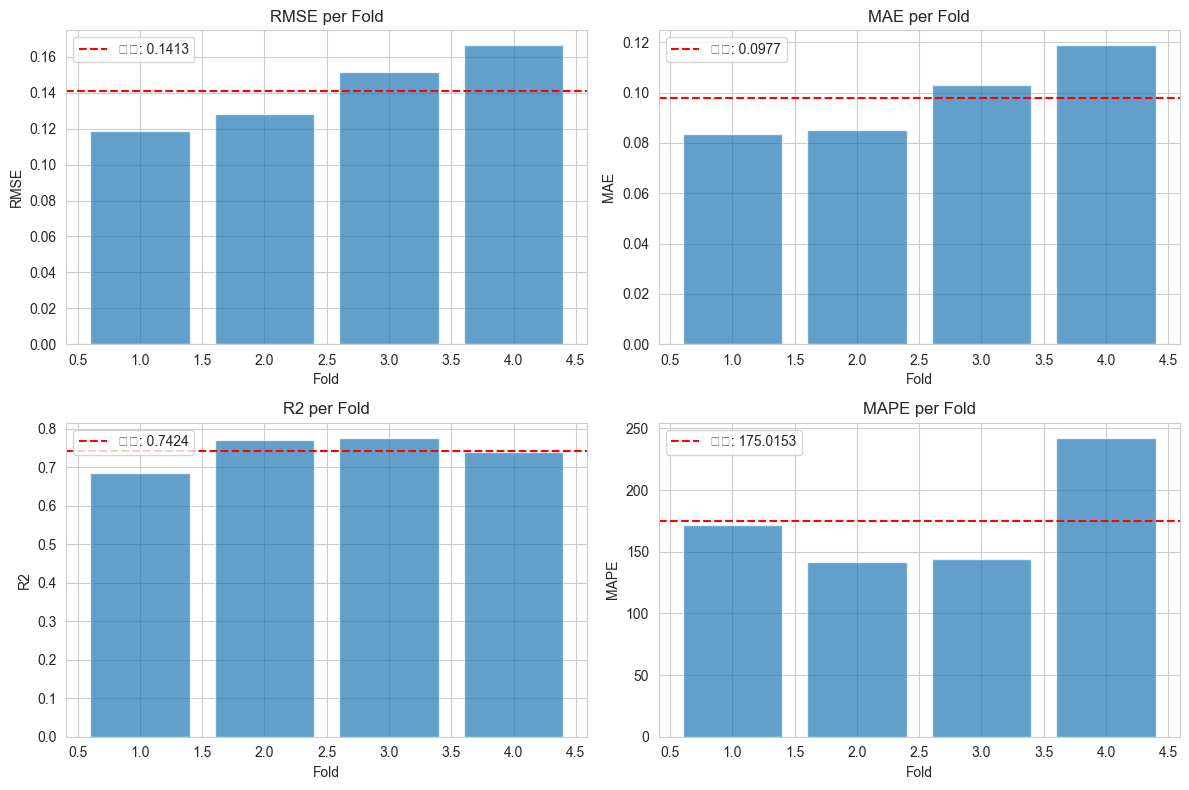

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

# 데이터 준비 (df가 미리 정의되어 있어야 함)
# X = df.loc[:, df.columns != 'maxElec_diff_scaled'].values.astype(np.float32)
# y = df['maxElec_diff_scaled'].values.astype(np.float32)

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout=0.3):
        super(MLPModel, self).__init__()
        layers = []
        
        # 입력층
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # 은닉층들
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # 출력층
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def train_model(model, X_train, y_train, X_val, y_val, num_epochs=200, 
                learning_rate=0.001, batch_size=32, patience=15):
    
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # DataLoader 생성
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 조기 종료를 위한 변수
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # 훈련
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # 검증
        model.eval()
        with torch.no_grad():
            X_val_device = X_val.to(device)
            y_val_device = y_val.to(device)
            val_outputs = model(X_val_device)
            val_loss = criterion(val_outputs.squeeze(), y_val_device).item()
            val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        # 조기 종료 체크
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"    조기 종료: epoch {epoch+1}")
                break
    
    # 최고 성능 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# MLP 모델 학습 및 평가
def run_mlp_model(X, y):
    print("=== MLP 모델 학습 시작 ===\n")
    
    # TimeSeriesSplit 설정
    tscv = TimeSeriesSplit(n_splits=5)
    
    fold_scores = []
    fold_predictions = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        try:
            print(f"--- Fold {fold+1} ---")
            
            # 데이터 분할
            X_train_fold = X[train_idx]
            X_test_fold = X[test_idx]
            y_train_fold = y[train_idx]
            y_test_fold = y[test_idx]
            
            # 정규화 (각 fold마다 별도로)
            scaler_X_fold = StandardScaler()
            scaler_y_fold = StandardScaler()
            
            X_train_scaled = scaler_X_fold.fit_transform(X_train_fold)
            X_test_scaled = scaler_X_fold.transform(X_test_fold)
            y_train_scaled = scaler_y_fold.fit_transform(y_train_fold.reshape(-1, 1)).flatten()
            y_test_scaled = scaler_y_fold.transform(y_test_fold.reshape(-1, 1)).flatten()
            
            # 텐서 변환
            X_train_tensor = torch.tensor(X_train_scaled)
            y_train_tensor = torch.tensor(y_train_scaled)
            X_test_tensor = torch.tensor(X_test_scaled)
            y_test_tensor = torch.tensor(y_test_scaled)
            
            # 모델 초기화
            input_size = X_train_scaled.shape[1]
            model = MLPModel(input_size)
            
            # 검증 데이터 분할 (훈련 데이터의 20%)
            val_size = int(0.2 * len(X_train_tensor))
            X_val = X_train_tensor[-val_size:]
            y_val = y_train_tensor[-val_size:]
            X_train_final = X_train_tensor[:-val_size]
            y_train_final = y_train_tensor[:-val_size]
            
            # 모델 훈련
            model = train_model(model, X_train_final, y_train_final, X_val, y_val)
            
            # 예측
            model.eval()
            with torch.no_grad():
                X_test_device = X_test_tensor.to(device)
                y_pred_scaled = model(X_test_device).squeeze().cpu().numpy()
            
            # 정규화 해제
            y_pred = scaler_y_fold.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
            y_true = y_test_fold
            
            # 평가 지표 계산
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            
            # 안전한 MAPE 계산
            epsilon = 1e-8
            mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100
            
            fold_scores.append({
                'RMSE': rmse, 'MAE': mae, 'MSE': mse, 
                'R2': r2, 'MAPE': mape
            })
            
            fold_predictions.append((y_true, y_pred, test_idx))
            
            print(f"  RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}, MAPE={mape:.2f}%")
            
        except Exception as e:
            print(f"  Fold {fold+1}: 오류 발생 - {str(e)}")
            continue
    
    if fold_scores:
        # 평균 성능 계산
        avg_rmse = np.mean([score['RMSE'] for score in fold_scores])
        avg_mae = np.mean([score['MAE'] for score in fold_scores])
        avg_mse = np.mean([score['MSE'] for score in fold_scores])
        avg_r2 = np.mean([score['R2'] for score in fold_scores])
        avg_mape = np.mean([score['MAPE'] for score in fold_scores])
        
        print(f"\n=== MLP 모델 최종 성능 ===")
        print(f"평균 RMSE: {avg_rmse:.4f} ± {np.std([score['RMSE'] for score in fold_scores]):.4f}")
        print(f"평균 MAE: {avg_mae:.4f} ± {np.std([score['MAE'] for score in fold_scores]):.4f}")
        print(f"평균 R²: {avg_r2:.4f} ± {np.std([score['R2'] for score in fold_scores]):.4f}")
        print(f"평균 MAPE: {avg_mape:.2f}% ± {np.std([score['MAPE'] for score in fold_scores]):.2f}%")
        
        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        metrics = ['RMSE', 'MAE', 'R2', 'MAPE']
        metric_values = [[score[metric] for score in fold_scores] for metric in metrics]
        
        for i, (metric, values) in enumerate(zip(metrics, metric_values)):
            ax = axes[i//2, i%2]
            ax.bar(range(1, len(values)+1), values, alpha=0.7)
            ax.set_title(f'{metric} per Fold')
            ax.set_xlabel('Fold')
            ax.set_ylabel(metric)
            ax.axhline(y=np.mean(values), color='red', linestyle='--', label=f'평균: {np.mean(values):.4f}')
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        return fold_scores, fold_predictions
    else:
        print("훈련 가능한 데이터가 없습니다.")
        return None, None

# 데이터가 준비되어 있다면 다음과 같이 실행
results, predictions = run_mlp_model(X, y)
